# Inventory Management with JAX

**Prepared for the Bank of Portugal Computational Economics Course (Oct 2025)**

**Author:** [John Stachurski](https://johnstachurski.net)

This notebook studies a stochastic dynamic inventory management model and
computes the optimal policy using
value function iteration (VFI) and Howard's policy iteration (HPI).

## Notebook Overview

The notebook structure is as follows:

1. **Model Setup**: Define the inventory dynamics, rewards, and transition probabilities
2. **Implement algorithms**: Implement VFI and HPI
2. **Solve**: Compute an optimal policy
5. **Simulation**: Monte Carlo simulation of inventory dynamics under the optimal policy

The notebook uses **JAX** for high-performance numerical computing with
automatic differentiation and just-in-time compilation.

## Problem Overview

We have an inventory system with:

- $K$: Maximum inventory capacity
- $\beta$: Discount factor
- $c$: Marginal cost (unit cost per order)
- $\kappa$: Fixed cost of ordering
- $\phi$: Demand shock distribution

Inventory evolves according to

$$
    X_{t+1} = \max(X_t - D_{t+1}, 0) + A_t
$$

where

- $X_t$ is current inventory (number of units),
- $D_{t+1}$ is an IID demand shock, and
- $A_t$ is the current order (number of units).

It will be convenient to work with the transition probability kernel

$$P(x, a, y) := \mathbb P\{X_{t+1}=y \,|\, X_t = x, A_t = a \}$$

With $\phi$ as the probability density function for demand,
the transition probability kernel obeys

\begin{align}
P(x, a, y) &= \sum_{d \geq 0} \mathbb{1}\{\max(x - d, 0) + a = y\} \phi(d) \\
&= \sum_{d < x} \mathbb{1}\{x - d + a = y\} \phi(d) + \sum_{d \geq x} \mathbb{1}\{a = y\} \phi(d) \\
&= \sum_{d < x} \mathbb{1}\{d = x + a - y\} \phi(d) + \mathbb{1}\{y = a\} F(x) \\
&= \mathbb{1}\{0 \leq x + a - y < x\} \phi(x + a - y) + \mathbb{1}\{y = a\} F(x)
\end{align}

Where $F(x) = P\{D \geq x\}$ is the survival function.

We begin with imports for numerical computing and visualization

In [21]:
import jax
import jax.numpy as jnp
import numpy as np
from typing import NamedTuple, Callable
import matplotlib.pyplot as plt

We begin by setting a global constant $K$ for maximum inventory capacity

K is made global to simplify JAX compilation: K determines array shapes (state space size = K+1), so it
   must be known at compile time.

Making K global avoids needing to to pass model instances as static in @jax.jit.

This is problematic because Model contains non-hashable arrays.

In [22]:
# Global constant for maximum inventory capacity
K = 50

Our default demand shock distribution will be geometric on 0, 1, ...

In [23]:
def ϕ_geometric(d, p=0.4):
    """PDF for demand shock: ϕ(d) = (1-p)^d * p"""
    return (1 - p)**d * p

Now we set up the `Model` class

In [24]:
class Model(NamedTuple):
        β: float            # discount factor
        c: float            # marginal cost
        κ: float            # fixed cost
        demand_pmf: jnp.ndarray  # precomputed demand PMF array


def create_model(
        β=0.98,
        c=0.1,
        κ=0.8,
        ϕ=ϕ_geometric,
        max_demand=100
    ) -> Model:
    """
    Create a Model instance with precomputed demand PMF.

    Parameters:
    - β: discount factor
    - c: marginal cost per unit
    - κ: fixed cost of ordering
    - ϕ: demand shock probability mass function
    - max_demand: maximum demand for numerical computation
    """
    d_vals = jnp.arange(max_demand + 1)
    demand_pmf = ϕ(d_vals)
    return Model(β=β, c=c, κ=κ, demand_pmf=demand_pmf)

## Transition Probabilities

The transition probability functions implement the mathematical formula derived
above.

These functions define how inventory evolves stochastically over time.

We begin with a function that computes $P(x, a, y)$ for a single combination of current state
$x$, action $a$, and next state $y$. It implements the two-term formula:

$$P(x, a, y) = \mathbb{1}\{0 \leq x + a - y < x\} \phi(x + a - y) + \mathbb{1}\{y = a\} F(x)$$

In [25]:
@jax.jit
def P_function(model, x, a, y):
    """
    Scalar function to compute P(x, a, y) for a single (x, a, y) triple.

    Implements the transition probability for inventory evolution:
    X_{t+1} = min(max(X_t - D_{t+1}, 0) + A_t, K)

    Returns 0 if action a would violate capacity constraint x + a > K.
    """
    β, c, κ, demand_pmf = model
    max_demand = len(demand_pmf) - 1

    # Compute  F(x) = P{D >= x}
    survival_mask = jnp.arange(max_demand + 1) >= x  # x, x+1, ..., max_demand
    Fx = jnp.sum(demand_pmf * survival_mask)

    # If action violates capacity constraint, return 0
    capacity_violated = (x + a > K)

    # Compute the first term 1{0 <= x + a - y < x} ϕ(x + a - y)
    d = x + a - y
    indicator = ((d >= 0) & (d < x))
    term1 = indicator * demand_pmf[d]

    # Compute the second term 1{y = a} F(x)
    indicator = (y == a)
    term2 = indicator * Fx

    # Return 0 if capacity violated, otherwise return computed probability
    return jnp.where(capacity_violated, 0.0, term1 + term2)

The next function leverages JAX's `vmap` to compute the entire 3D transition tensor $P(x, a, y)$ efficiently.

The nested `vmap` operations vectorize over:

1. Next states $y$ (innermost)
2. Actions $a$ (middle)
3. Current states $x$ (outermost)

This creates a tensor of shape `(S, S, S)` where `S = K + 1`.

In [26]:
@jax.jit
def P_array(model):
    """
    Vmap-based computation of the transition probability kernel P(x, a, y).
    Uses JAX's vmap to vectorize the scalar function over all (x, a, y)
    combinations.
    """
    β, c, κ, demand_pmf = model
    S = K + 1

    # Create all combinations of (x, a, y) indices
    x_vals = jnp.arange(S)
    a_vals = jnp.arange(S)
    y_vals = jnp.arange(S)

    # Use vmap to compute P(x,a,y) for all combinations
    P_vmap_y   = jax.vmap(P_function, (None, None, None, 0))
    P_vmap_ay  = jax.vmap(P_vmap_y,   (None, None, 0, None))
    P_vmap_xay = jax.vmap(P_vmap_ay,  (None, 0, None, None))

    return P_vmap_xay(model, x_vals, a_vals, y_vals)

## Reward Structure: Economics of Inventory Management

The reward functions capture the economic trade-offs in inventory management:

This function implements the expected reward:

$$r(x, a) = \sum_{d \geq 0} \min(x, d) \phi(d) - ca - \kappa \mathbb{1}\{a > 0\}$$

The components are:
- Revenue: $\sum_{d \geq 0} \min(x, d) \phi(d)$ - expected sales (limited by inventory)
- Ordering Cost: $ca$ - variable cost proportional to order size
- Fixed Cost: $\kappa \mathbb{1}\{a > 0\}$ - fixed cost incurred when ordering any positive amount

In [27]:
def reward_function(model, x, a):
    """
    The flow (expected) reward function

        r(x, a) = Σ_{d >= 0} min(x, d) ϕ(d) - ca - κ (a > 0)

    This function works with any demand distribution by computing the sum
    numerically.
    """
    β, c, κ, demand_pmf = model
    max_demand = len(demand_pmf) - 1

    d_vals = jnp.arange(max_demand + 1)
    sales_per_demand = jnp.minimum(x, d_vals)
    expected_sales = jnp.sum(sales_per_demand * demand_pmf)
    return expected_sales - c * a - jnp.greater(a, 0) * κ

Next we use `vmap` to compute the reward matrix $r(x, a)$ for all state-action
pairs simultaneously.

This 2D array has shape `(S, S)` and is used extensively in both VFI and policy iteration.

In [28]:
@jax.jit
def reward_array(model):
    """
    Vmap-based computation of the reward array r(x, a).

    """
    β, c, κ, demand_pmf = model
    S = K + 1

    # Create all combinations of (x, a) indices
    x_vals = jnp.arange(S)
    a_vals = jnp.arange(S)

    # Use vmap to compute r(x,a) for all combinations
    r_vmap_a   = jax.vmap(reward_function, (None, None, 0))
    r_vmap_xa  = jax.vmap(r_vmap_a,        (None, 0,    None))

    return r_vmap_xa(model, x_vals, a_vals)

## Value Function Iteration (VFI)

For VFI we repeatedly apply the Bellman operator until convergence.

First we implement the Bellman operator:

$$T(v)(x) = \max_a \left[ r(x, a) + \beta \sum_y P(x, a, y) v(y) \right]$$

We use the following steps:

1. Action-Value Computation: $B = r + \beta \sum_y P \cdot v$ computes $Q(x,a)$ for all state-action pairs
2. Policy Extraction: `jnp.max(B, axis=1)` finds the maximum over actions for each state

In [29]:
@jax.jit
def T(model, P, r, v):
    β, c, κ, demand_pmf = model
    B = r + β * jnp.sum(P * v, axis=2)
    return jnp.max(B, axis=1)

### vfi(): Iterative Convergence

The main VFI algorithm iterates the Bellman operator:

1. Start with initial guess $v^0 = 0$
2. Update: $v^{k+1} = T(v^k)$
3. Continue until $\|v^{k+1} - v^k\| < \text{tolerance}$

Under our assumptions, VFI converges to the unique optimal value function.

In [30]:
def vfi(model, max_iter=10_000, tol=1e-6):
    β, c, κ, demand_pmf = model
    P = P_array(model)
    r = reward_array(model)
    error = tol + 1
    i = 0
    v = jnp.zeros(K+1)

    while i < max_iter and error > tol:
        new_v = T(model, P, r, v)
        error = jnp.max(jnp.abs(new_v - v))
        v = new_v

    return v

## Howard's Policy Iteration: An Alternative Approach

Policy iteration takes a different approach from VFI by alternating between two
steps: policy evaluation and policy improvement.

This method often converges in fewer iterations than VFI.

### policy_evaluation(): Solving the Linear System

Given a policy $\sigma$, this function computes the value function by solving:

$$(I - \beta P_\sigma) v = r_\sigma$$

The steps are:

- $P_\sigma$ extraction: `P[jnp.arange(S), σ, :]` - transition matrix under policy $\sigma$
- $r_\sigma$ construction: `r[jnp.arange(S), σ]` - rewards under policy $\sigma$
- Linear system solution: Direct matrix inversion using `jnp.linalg.solve`

In [31]:
@jax.jit
def policy_evaluation(model, P, r, σ):
    """
    Policy evaluation: solve (I - β P_σ) v = r_σ for value function v
    where P_σ and r_σ are transition matrix and rewards under policy σ

    Solves the linear system directly using matrix inversion
    """
    β, c, κ, demand_pmf = model
    S = K + 1
    x_indices = jnp.arange(S)
    # Extract transition probabilities and rewards for the given policy
    P_σ = P[x_indices, σ, :]
    r_σ = r[x_indices, σ]

    # Solve (I - β P_σ) v = r_σ directly
    A = jnp.eye(S) - β * P_σ
    v = jnp.linalg.solve(A, r_σ)

    return v

Let's look carefully at how we build `r_σ`.

The reward array `r` has shape `(S, S)` where `S = K + 1` is the size of our state space.

The element `r[x, a]` represents the expected reward for being in state `x` and taking action `a`.

Given a policy $\sigma$ (represented as an array where `σ[x]` gives the action to take in state `x`), we need to extract the rewards that would be obtained by following this policy.

The line

```python
r_σ = r[x_indices, σ]
```

selects `r[i, σ[i]]` for each `i`

Here's a small example to illustrate r_sigma construction.

In [32]:
# Create a simple 4x4 reward matrix for illustration
S_example = 4
r_example = jnp.array([
    [1.0, 2.0, 3.0, 4.0],    # rewards for state 0
    [5.0, 6.0, 7.0, 8.0],    # rewards for state 1
    [9.0, 10.0, 11.0, 12.0], # rewards for state 2
    [13.0, 14.0, 15.0, 16.0] # rewards for state 3
])

# Example policy: σ[x] = action to take in state x
policy_example = jnp.array([2, 0, 3, 1])  # state 0→action 2, state 1→action 0, etc.

print("Reward matrix r:")
print(r_example)
print()
print("Policy σ (action for each state):", policy_example)
print()

# Construct r_sigma using advanced indexing
state_indices = jnp.arange(S_example)  # [0, 1, 2, 3]
r_sigma_example = r_example[state_indices, policy_example]

print("State indices:", state_indices)
print("Advanced indexing: r[state_indices, policy]")
print("This selects:")
for i in range(S_example):
    print(f"  r[{i}, {policy_example[i]}] = {r_example[i, policy_example[i]]}")
print()
print("Resulting r_sigma:", r_sigma_example)

Reward matrix r:
[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]
 [13. 14. 15. 16.]]

Policy σ (action for each state): [2 0 3 1]

State indices: [0 1 2 3]
Advanced indexing: r[state_indices, policy]
This selects:
  r[0, 2] = 3.0
  r[1, 0] = 5.0
  r[2, 3] = 12.0
  r[3, 1] = 14.0

Resulting r_sigma: [ 3.  5. 12. 14.]


### Greedy Policy Update

The next function computes the greedy policy with respect to current value function:

$$\sigma(x) = \arg\max_a \left[ r(x,a) + \beta \sum_y P(x,a,y) v(y) \right]$$

In [33]:
@jax.jit
def get_greedy(model, P, r, v):
    """
    Policy improvement: compute greedy policy with respect to value function v
    Returns new policy σ(x) = argmax_a [r(x,a) + β Σ_y P(x,a,y) v(y)]
    """
    β, c, κ, demand_pmf = model
    # Compute Q(x,a) = r(x,a) + β Σ_y P(x,a,y) v(y)
    Q = r + β * jnp.sum(P * v, axis=2)
    # Return greedy policy
    return jnp.argmax(Q, axis=1)

### howard_policy_iteration(): The Complete Algorithm

Now we can implement HPI:

1. Initialize: Start with arbitrary policy (e.g., $\sigma(x) = 0$ for all $x$)
2. Policy Evaluation: Solve for $v^\sigma$ given current policy $\sigma$
3. Policy Improvement: Compute greedy policy $\sigma'$ with respect to $v^\sigma$
4. Convergence Check: If $\sigma' = \sigma$, stop; otherwise set $\sigma = \sigma'$ and repeat

In [34]:
def howard_policy_iteration(model, max_iter=1000, tol=1e-6):
    """
    Howard's policy iteration algorithm.
    Alternates between policy evaluation and policy improvement until
    convergence.
    """
    β, c, κ, demand_pmf = model
    S = K + 1
    P = P_array(model)
    r = reward_array(model)

    # Initialize with zero policy (order nothing)
    σ = jnp.zeros(S, dtype=int)

    for i in range(max_iter):
        # Policy evaluation
        v = policy_evaluation(model, P, r, σ)
        # Policy improvement
        new_σ = get_greedy(model, P, r, v)
        # Check for convergence
        if jnp.array_equal(σ, new_σ):
            return v, new_σ
        σ = new_σ

    print(f"Warning: Hit max-iteration bound {max_iter}.")
    return v, σ


def get_optimal_policy(model, v):
    """
    Extract the optimal policy from a value function using policy improvement.
    """
    P = P_array(model)
    r = reward_array(model)
    return get_greedy(model, P, r, v)

## Solving the Model: Comparing VFI and Policy Iteration

Now we solve the inventory management problem using both algorithms and compare their results.

This comparison demonstrates that both methods converge to the same optimal policy.

In [15]:
model = create_model()
β, c, κ, demand_pmf = model

P = P_array(model)
r = reward_array(model)

# Solve using value function iteration
print("Solving with Value Function Iteration...")
v_vfi = vfi(model)
policy_vfi = get_optimal_policy(model, v_vfi)

# Solve using Howard's policy iteration
print("Solving with Howard's Policy Iteration...")
v_hpi, policy_hpi = howard_policy_iteration(model)

# Compare results
print("\nComparison of methods:")
print(f"VFI vs HPI - Value functions equal: "
      f"{jnp.allclose(v_vfi, v_hpi, atol=1e-6)}")
print(f"VFI vs HPI - Policies equal: "
      f"{jnp.array_equal(policy_vfi, policy_hpi)}")

v = v_vfi

Solving with Value Function Iteration...
Solving with Howard's Policy Iteration...

Comparison of methods:
VFI vs HPI - Value functions equal: True
VFI vs HPI - Policies equal: True


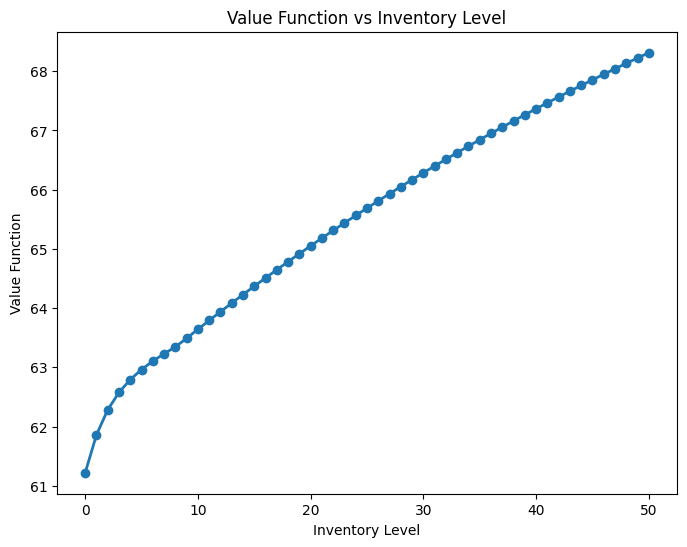

In [16]:
# Plot value function
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(range(K + 1), v, 'o-', linewidth=2, markersize=6)
ax.set_xlabel('Inventory Level')
ax.set_ylabel('Value Function')
ax.set_title('Value Function vs Inventory Level')
plt.show()

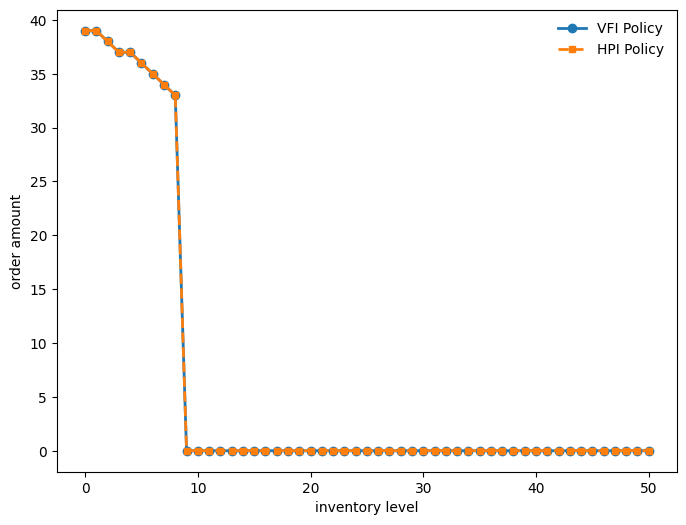

In [18]:
# Plot policies
fig, ax = plt.subplots(figsize=(8, 6))
x_vals = range(K + 1)
ax.plot(x_vals, policy_vfi, 'o-', linewidth=2, markersize=6,
        label='VFI Policy')
ax.plot(x_vals, policy_hpi, '--s', linewidth=2, markersize=4,
        label='HPI Policy')
ax.set_xlabel('inventory level')
ax.set_ylabel('order amount')
ax.legend(frameon=False)
plt.show()

Notice that

- Both VFI and HPI converge to identical solutions
- No ordering occurs above a certain threshold
- Orders are relatively large

## Simulation of Inventory Dynamics

To and understand the dynamics of the optimal policy, we simulate the inventory
system over time using the computed optimal policy.

In the code below we

- Set the initial condition as: Start with maximum inventory (K units)
- Sample from the geometric distribution using inverse CDF method
- Use the optimal policy to determine orders at each time step

In [19]:
# Simulation of inventory dynamics under optimal policy

# Simulation parameters
T = 100  # number of periods
x_start = K  # start with full inventory

# Set up simulation
key = jax.random.PRNGKey(42)
inventory = jnp.zeros(T + 1)
orders = jnp.zeros(T)
demands = jnp.zeros(T)

# Initial inventory
inventory = inventory.at[0].set(x_start)

# Simulate dynamics
for t in range(T):
    x_t = int(inventory[t])

    # Optimal action from policy
    a_t = policy_vfi[x_t]
    orders = orders.at[t].set(a_t)

    # Sample demand from geometric distribution
    key, subkey = jax.random.split(key)
    # Sample from geometric by inverse CDF method
    u = jax.random.uniform(subkey)
    demand_cdf_cumsum = jnp.cumsum(demand_pmf)
    d_t = jnp.sum(demand_cdf_cumsum < u)
    demands = demands.at[t].set(d_t)

    # Update inventory: X_{t+1} = max(X_t - D_{t+1}, 0) + A_t
    x_next = max(x_t - d_t, 0) + a_t
    inventory = inventory.at[t + 1].set(x_next)

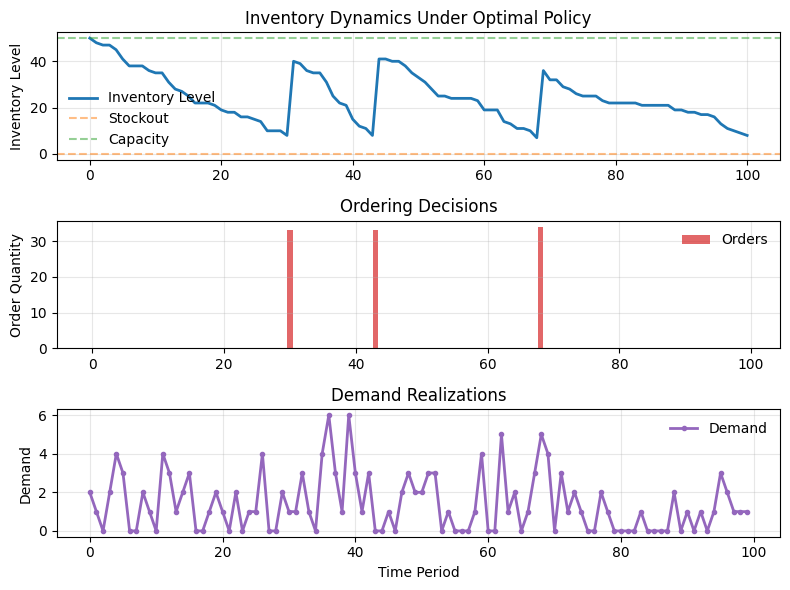

In [20]:
# Plot simulation results
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6))

# Get matplotlib's default color cycle
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

# Inventory trajectory
ax1.plot(range(T + 1), inventory, linewidth=2, label='Inventory Level',
         color=colors[0])
ax1.axhline(y=0, linestyle='--', alpha=0.5, label='Stockout',
            color=colors[1])
ax1.axhline(y=K, linestyle='--', alpha=0.5, label='Capacity',
            color=colors[2])
ax1.set_ylabel('Inventory Level')
ax1.set_title('Inventory Dynamics Under Optimal Policy')
ax1.legend(frameon=False)
ax1.grid(True, alpha=0.3)

# Orders
ax2.bar(range(T), orders, alpha=0.7, label='Orders', color=colors[3])
ax2.set_ylabel('Order Quantity')
ax2.set_title('Ordering Decisions')
ax2.legend(frameon=False)
ax2.grid(True, alpha=0.3)

# Demand
ax3.plot(range(T), demands, linewidth=2, marker='o', markersize=3,
         label='Demand', color=colors[4])
ax3.set_ylabel('Demand')
ax3.set_xlabel('Time Period')
ax3.set_title('Demand Realizations')
ax3.legend(frameon=False)
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()